# Lab 3 - Query Expansion

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

349

In [3]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [4]:
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/usr/local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [07:24<00:00,  1.27s/it]


## Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [5]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [10]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? In the past year,
there have been minimal changes in the executive team at our company.
The executive team remains stable, with a high level of continuity in
leadership positions. This consistency in leadership helps maintain
organizational stability and continuity in the execution of the
company's strategic objectives.


In [11]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

to be their authentic selves and do their best work every day. we
support multiple highly active employee resource groups for women,
families, racial and ethnic minorities, military, people with
disabilities, and employees who identify as lgbtqia +, where employees
can go for support, networking, and community - building. as described
in our 2021 proxy statement, annual performance and compensation
reviews of our senior leadership team include an evaluation of their
contributions to employee culture and diversity. to ensure
accountability over time, we publicly disclose our progress on a
multitude of workforce metrics including : • detailed breakdowns of
gender, racial, and ethnic minority representation in our employee
population, with data by job types, levels, and segments of our
business. • our eeo - 1 report ( equal employment opportunity ). •
disability representation. • pay equity ( see details below ).

unresolved with the irs, evaluating management ’ s estimates relating
to th

In [12]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


(-1.3263971537351609, 9.052497419714928, 5.279644966125488, 11.559544563293457)

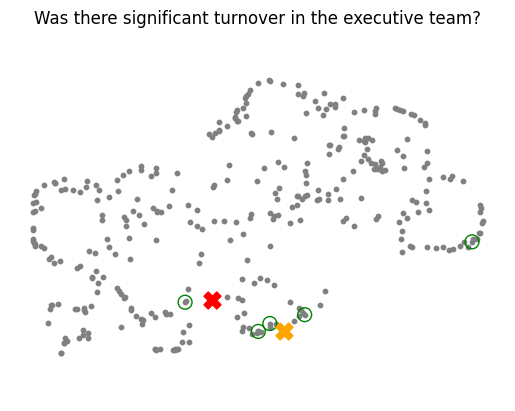

In [13]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

#the answer is retrieved close to the joint query 
# the retrieved asnwer has better content

## Expansion with multiple queries


In [14]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [15]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- What were the main drivers behind revenue growth?
- How did changes in pricing strategy impact revenue?
- Were there any significant new products or services that boosted revenue?
- Did changes in market demand have a noticeable effect on revenue?
- How did foreign exchange rates affect revenue growth?


In [16]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
#this is essential as the queries are simialr to each other
#there may be duplication of docs retrieved

unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [17]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


In [18]:
result_embeddings = results['embeddings']
#we need to flatten the embeddings as we have a list of embeddings
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


(-1.3263971537351609, 9.052497419714928, 5.279644966125488, 11.559544563293457)

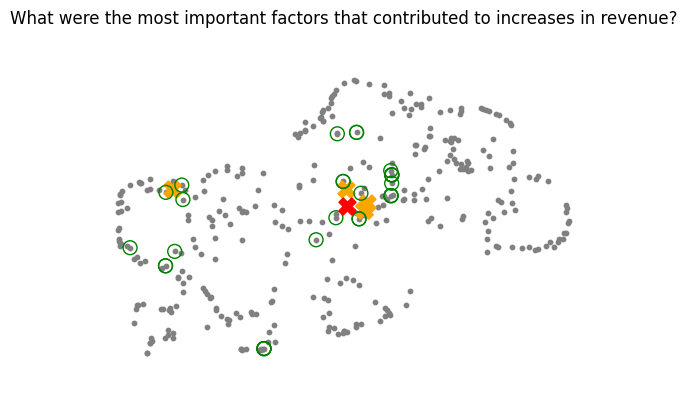

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

#now we were able to retrieve diff relevant docs depsite
#being located far away using multiple queries
#this wud have not been possible by using sinle query